In [28]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import seaborn as sns

## Objective: Predict Household Electricity Consumption by day

Read the data into df

In [29]:
df = pd.read_excel('D202.xlsx')

Eliminate columns that dont involve electricity consumption or date. 

In [30]:
df = df.drop(['TYPE', 'START TIME', 'END TIME', 'UNITS', 'NOTES', 'COST'], axis=1)

In [31]:
df = df.set_index(df['DATE'], drop=True)

In [32]:
df = df.fillna(method='ffill')

In [33]:
df = df.drop(['DATE'], axis = 1)

Resample data consumption by day

In [34]:
df = df.resample('D').sum()

Create a function to determine stationarity. This includes rolling mean, rolling standard deviation, and the test to determine if a dataset is stationary aka the Dickey Fuller Test. 

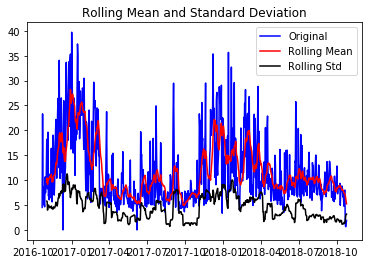

Results of dickey fuller test
Test Statistics                 -2.423278
p-value                          0.135274
No. of lags used                19.000000
Number of observations used    713.000000
critical value (5%)             -2.865602
critical value (1%)             -3.439555
critical value (10%)            -2.568933
dtype: float64


In [35]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Find rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['USAGE'],autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

Take the logarithm of the function. 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


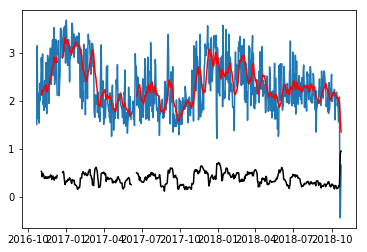

In [36]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

Now find the difference between the logarithm of the dataframe and the moving average at the various points.  

In [37]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

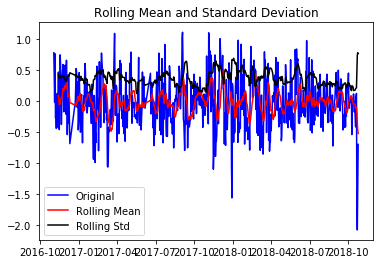

Results of dickey fuller test
Test Statistics               -8.033022e+00
p-value                        1.935483e-12
No. of lags used               1.800000e+01
Number of observations used    6.790000e+02
critical value (5%)           -2.865806e+00
critical value (1%)           -3.440017e+00
critical value (10%)          -2.569042e+00
dtype: float64


In [38]:
test_stationarity(df_log_moving_avg_diff)

In [39]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

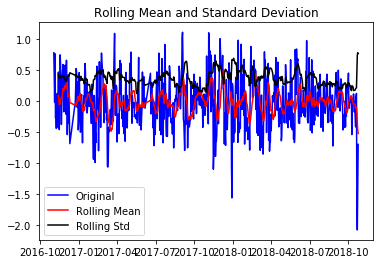

Results of dickey fuller test
Test Statistics               -8.033022e+00
p-value                        1.935483e-12
No. of lags used               1.800000e+01
Number of observations used    6.790000e+02
critical value (5%)           -2.865806e+00
critical value (1%)           -3.440017e+00
critical value (10%)          -2.569042e+00
dtype: float64


In [40]:
test_stationarity(df_log_moving_avg_diff)

In [41]:
weighted_average = df_log.ewm(halflife=3, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
df_log_moving_avg_diff.dropna(inplace=True)

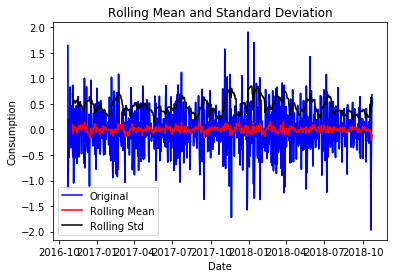

Results of dickey fuller test
Test Statistics               -9.130509e+00
p-value                        3.031054e-15
No. of lags used               1.800000e+01
Number of observations used    7.090000e+02
critical value (5%)           -2.865625e+00
critical value (1%)           -3.439607e+00
critical value (10%)          -2.568945e+00
dtype: float64


In [42]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

#Let us test the stationarity of our resultant series
df_log_diff = df_log_diff.replace([np.inf, -np.inf], np.nan)
df_log_diff.dropna(inplace=True)

test_stationarity(df_log_diff)

Now remove any strange values such as infiniti or na values. 

In [43]:
df_log = df_log.replace([np.inf, -np.inf], np.nan)
df_log.dropna(inplace=True)

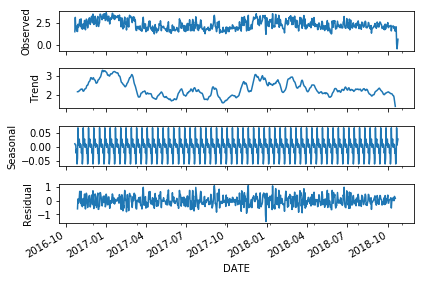

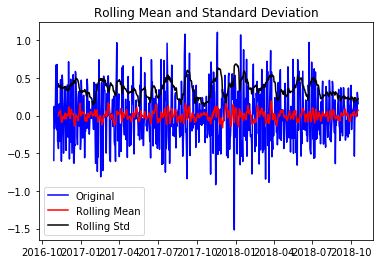

Results of dickey fuller test
Test Statistics               -1.029769e+01
p-value                        3.436680e-18
No. of lags used               2.000000e+01
Number of observations used    6.980000e+02
critical value (5%)           -2.865690e+00
critical value (1%)           -3.439753e+00
critical value (10%)          -2.568980e+00
dtype: float64


In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()

trend = result.trend
trend.dropna(inplace=True)

seasonality = result.seasonal
seasonality.dropna(inplace=True)

residual = result.resid
residual.dropna(inplace=True)

test_stationarity(residual)

In [45]:
dataset = df_log["USAGE"].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [46]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 553 samples, validate on 116 samples
Epoch 1/20
553/553 [==============================] - 2s 3ms/step - loss: 0.3483 - val_loss: 0.0741
Epoch 2/20
553/553 [==============================] - 0s 346us/step - loss: 0.0442 - val_loss: 0.0257
Epoch 3/20
553/553 [==============================] - 0s 350us/step - loss: 0.0421 - val_loss: 0.0403
Epoch 4/20
553/553 [==============================] - 0s 356us/step - loss: 0.0275 - val_loss: 0.0126
Epoch 5/20
553/553 [==============================] - 0s 328us/step - loss: 0.0171 - val_loss: 0.0124
Epoch 6/20
553/553 [==============================] - 0s 312us/step - loss: 0.0194 - val_loss: 0.0114
Epoch 7/20
553/553 [==============================] - 0s 296us/step - loss: 0.0174 - val_loss: 0.0123
Epoch 8/20
553/553 [==============================] - 0s 413us/step - loss: 0.0173 - val_loss: 0.0127
Epoch 9/20
553/553 [==============================] - 0s 348us/step - loss: 0.0156 - val_loss: 0.0116
Epoch 10/20
553/553 [=================

In [47]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

('Train Mean Absolute Error:', 0.3803384504487967)
('Train Root Mean Squared Error:', 0.4650679262929251)
('Test Mean Absolute Error:', 0.28063856678209287)
('Test Root Mean Squared Error:', 0.4384758133573284)


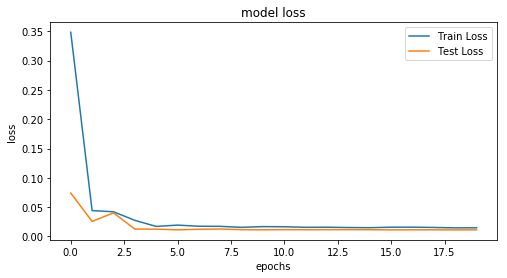

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

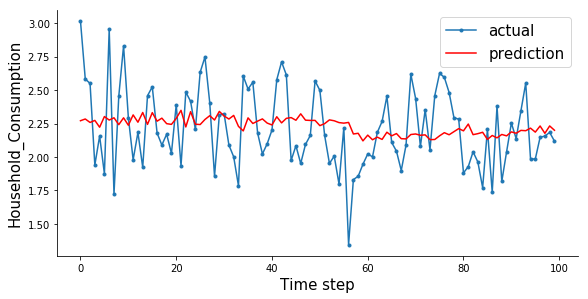

In [49]:
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Household_Consumption', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();